In [5]:
# @author Nikhil Maserang
# @date 2023/04/12

import numpy as np
import scipy.ndimage as spnd
import matplotlib.pyplot as plt
import utils as ut

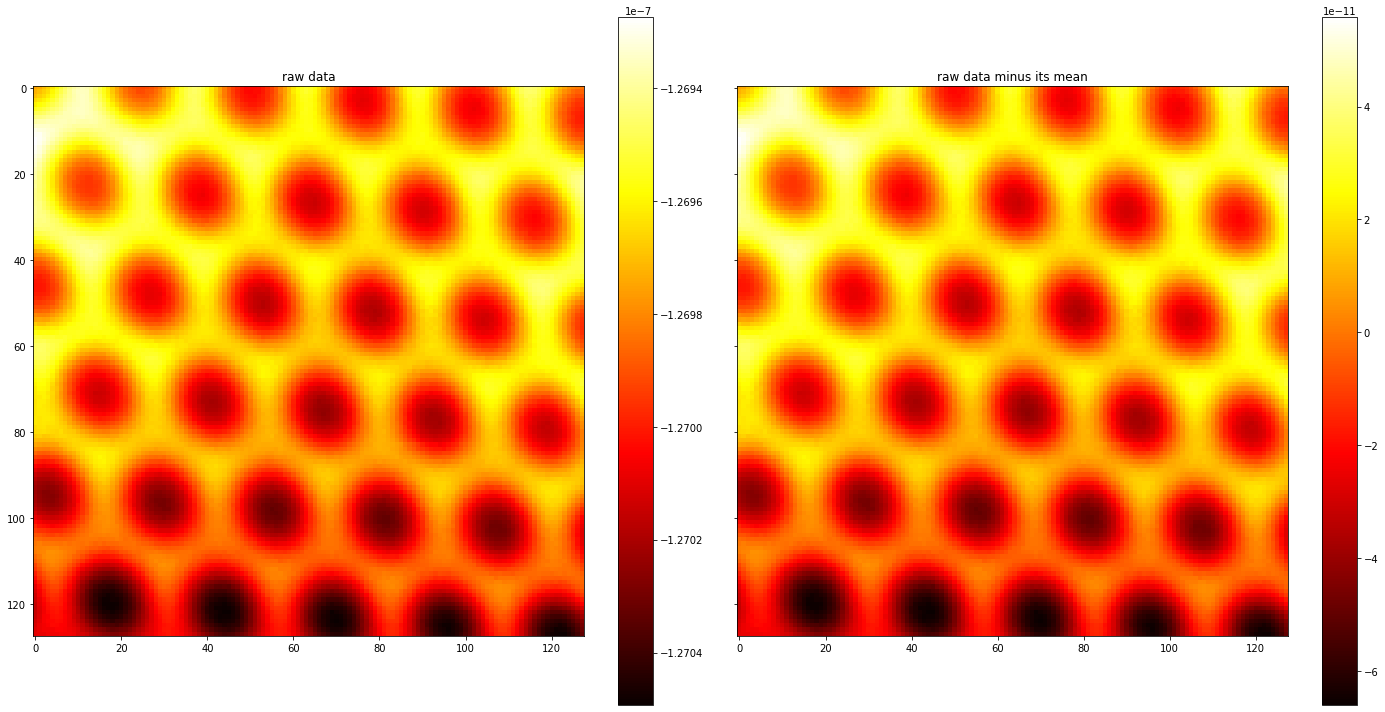

In [11]:
# get sxm data from file
fname = "testing.sxm"
fname = "images/m008.sxm"
data = ut.get_sxm_data(fname)

# remove the mean, 'centering' the data around 0;
# this is so the scalar FFT component doesn't mess up our results
centered_data = data - np.mean(data)

# plot
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 10), layout='tight')

plt.colorbar(axs[0].imshow(data, cmap="hot"), ax=axs[0])
plt.colorbar(axs[1].imshow(centered_data, cmap="hot"), ax=axs[1])

axs[0].set_title("raw data")
axs[1].set_title("raw data minus its mean")

plt.show()

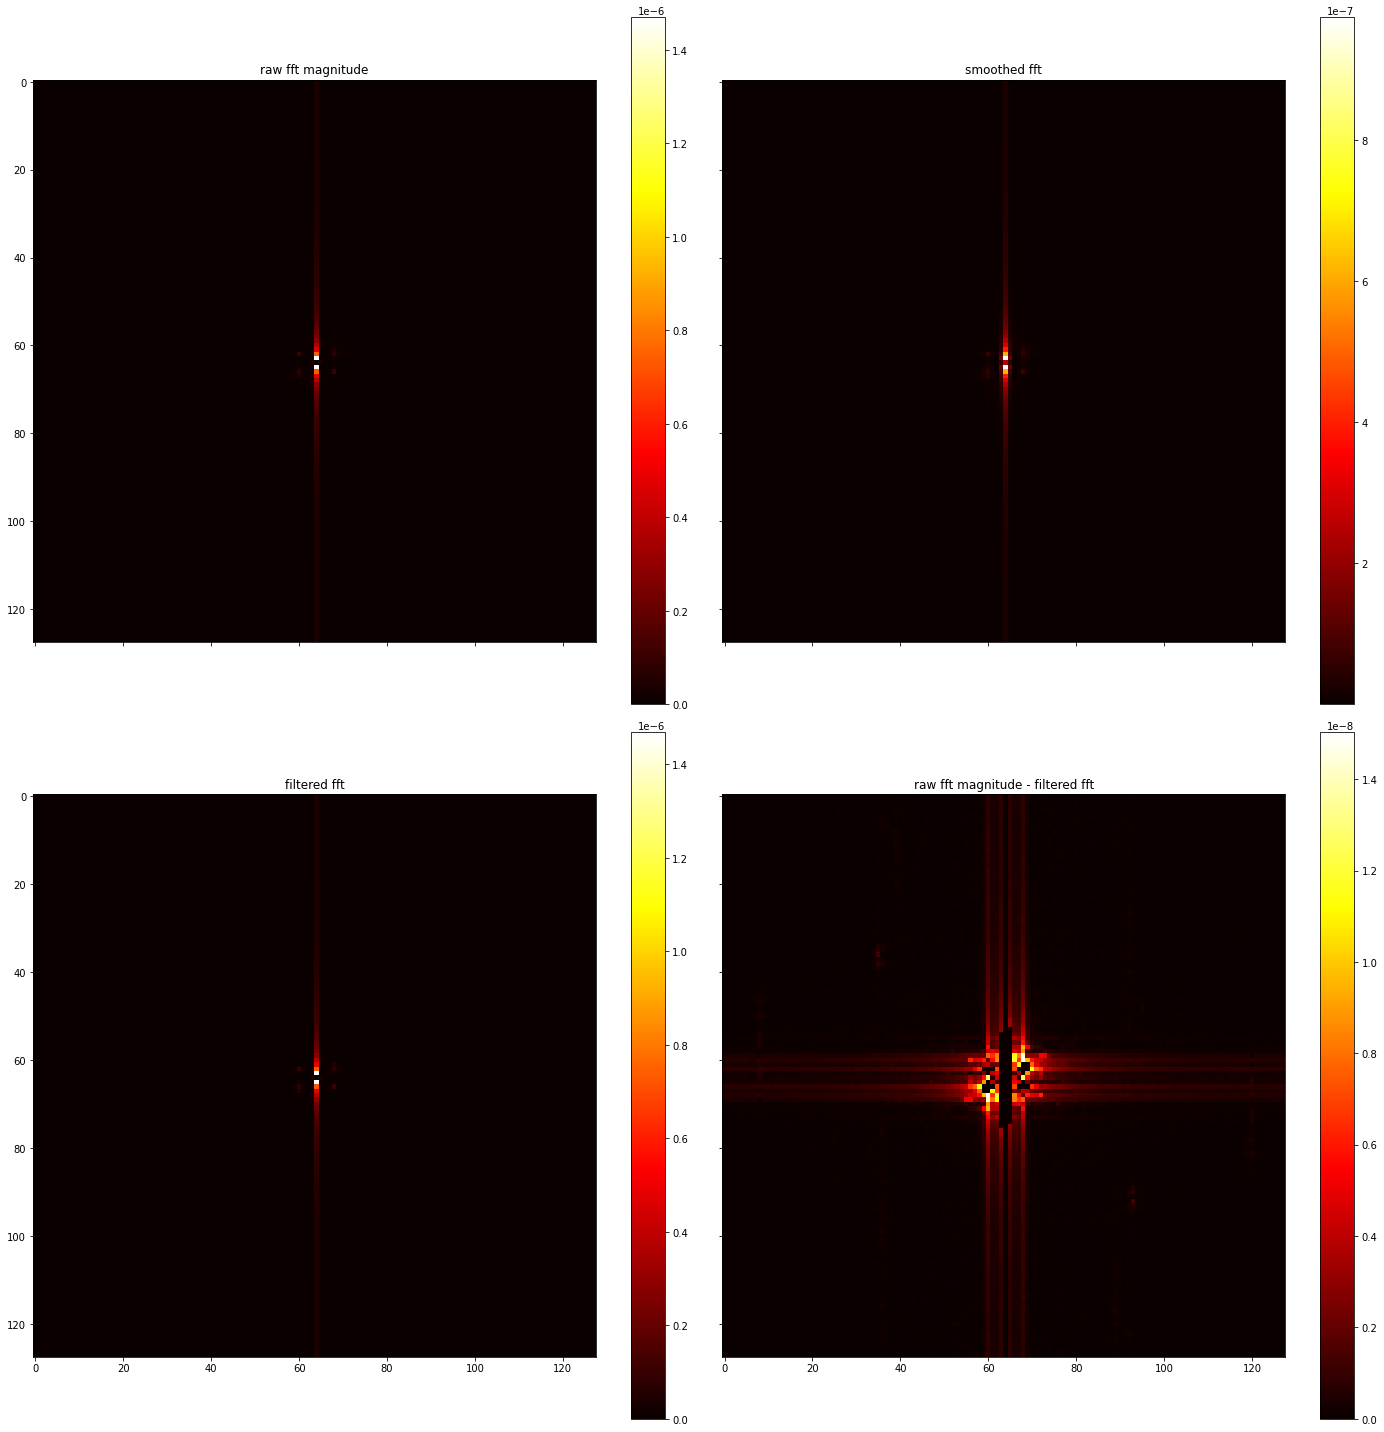

In [7]:
# perform shifted FFT on the data; output is complex but we care about magnitude, so we take abs
fft = np.abs(ut.run_shifted_fft(centered_data))

# perform Gaussian smoothing
smoothedfft = spnd.gaussian_filter(fft, 0.5)

# filter out any data points under the average + stddev by setting them to 0
threshold = np.average(smoothedfft) + np.std(smoothedfft)
mask = (smoothedfft >= threshold)
filteredfft = mask * fft

# plot
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20, 20), layout='tight')

plt.colorbar(axs[0, 0].imshow(fft, cmap='hot'), ax=axs[0, 0])
plt.colorbar(axs[0, 1].imshow(smoothedfft, cmap='hot'), ax=axs[0, 1])
plt.colorbar(axs[1, 0].imshow(filteredfft, cmap='hot'), ax=axs[1, 0])
plt.colorbar(axs[1, 1].imshow(fft - filteredfft, cmap='hot'), ax=axs[1, 1])

axs[0, 0].set_title("raw fft magnitude")
axs[0, 1].set_title("smoothed fft")
axs[1, 0].set_title("filtered fft")
axs[1, 1].set_title("raw fft magnitude - filtered fft")

plt.show()

In [8]:
# compute a rolling maximum across the image
rolling_max = spnd.maximum_filter(filteredfft, 11)

# find points where local max has same value as point itself to get maxes
maxes = (rolling_max == filteredfft) * filteredfft

# blot out the middle to remove the extraneous points near 0
blotted_maxes = maxes.copy()
ut.set_img_center(blotted_maxes, 5, 0)

# get bitmap of nonzero matrix entries
maxes_bitmap = (blotted_maxes != 0)

# plot
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20, 20), layout='tight')

plt.colorbar(axs[0, 0].imshow(rolling_max, cmap='hot'), ax=axs[0, 0])
plt.colorbar(axs[0, 1].imshow(maxes, cmap='hot'), ax=axs[0, 1])
plt.colorbar(axs[1, 0].imshow(blotted_maxes, cmap='hot'), ax=axs[1, 0])
plt.colorbar(axs[1, 1].imshow(maxes_bitmap, cmap='hot'), ax=axs[1, 1])

axs[0, 0].set_title("rolling max filter")
axs[0, 1].set_title("local maxes")
axs[1, 0].set_title("local maxes without zero frequencies")
axs[1, 1].set_title("local maxes bitmap")

plt.show()

AttributeError: module 'utils' has no attribute 'set_img_center'

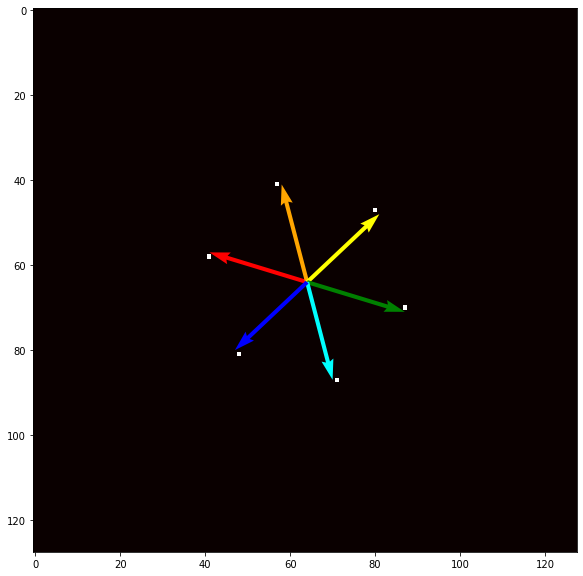

In [ ]:
# get hexagon vertices and order them
vertices = np.array(np.nonzero(maxes_bitmap)).T
vertices = ut.order_vertices(vertices)

# display radial vectors from centroid to vertices
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(maxes_bitmap, cmap="hot")
ut.plot_hex_radii(ax, vertices)
plt.show()

True


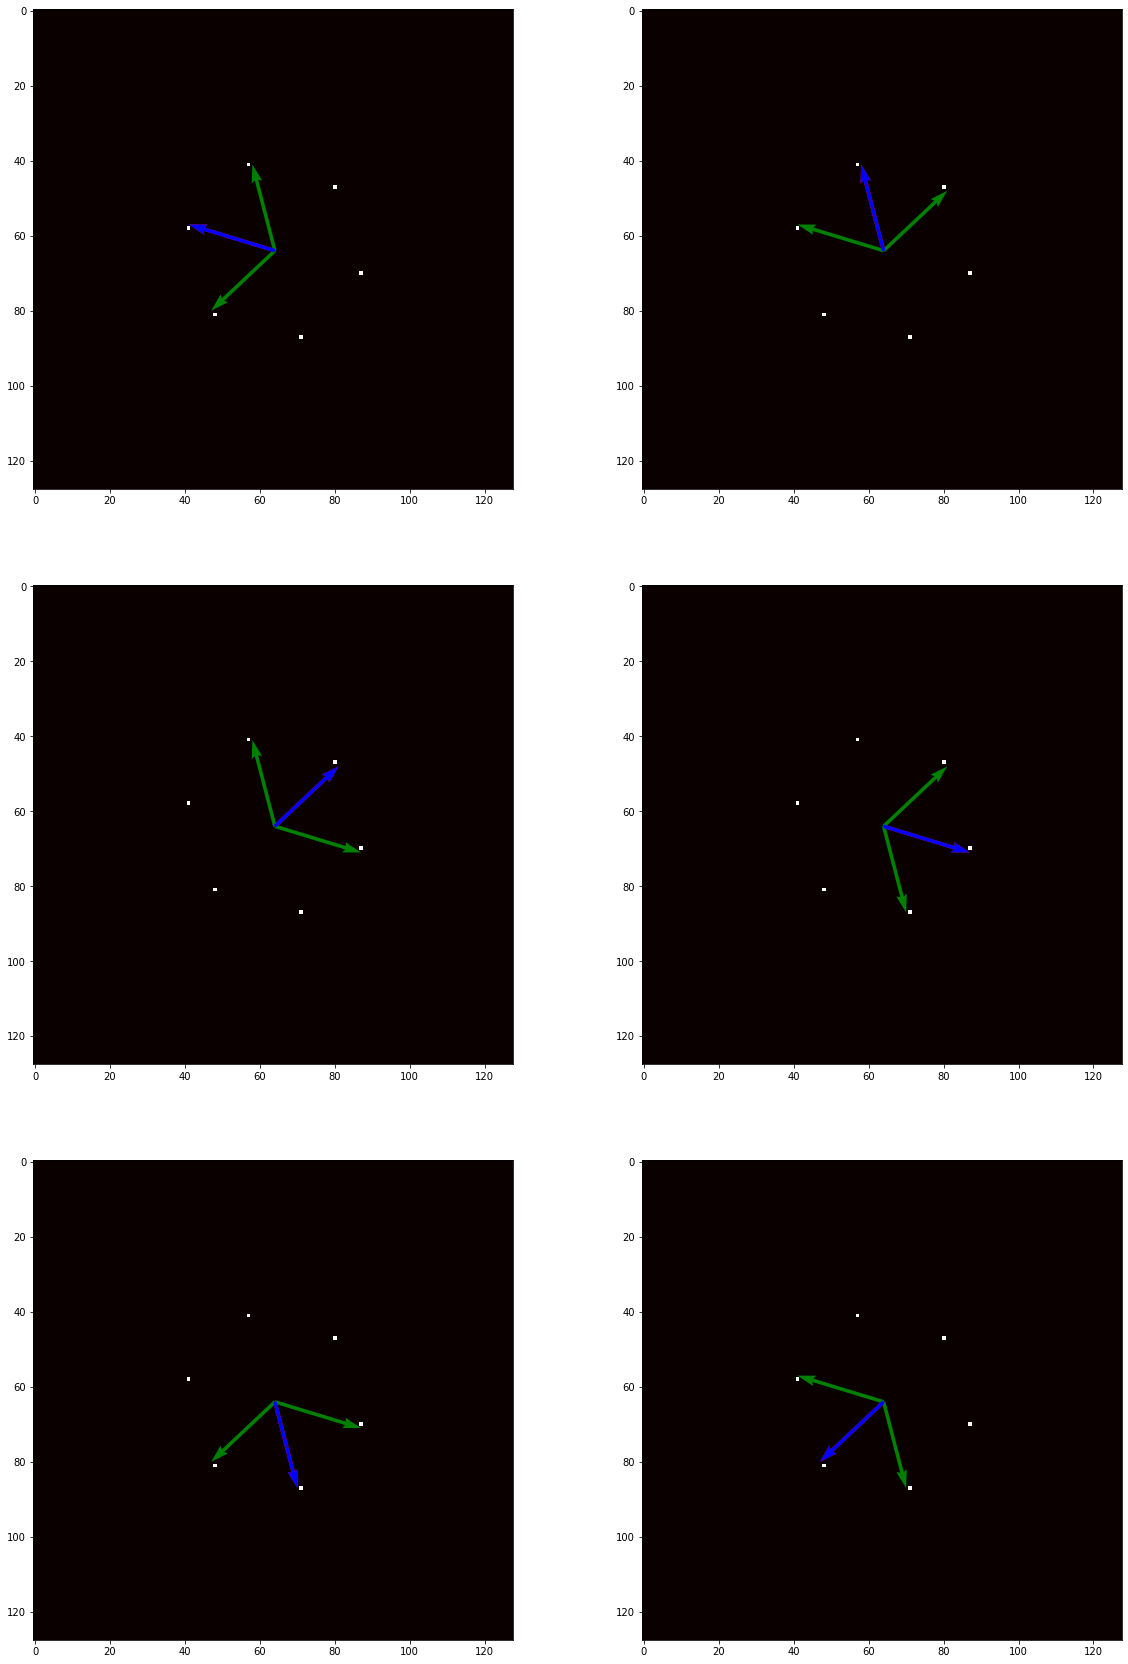

In [ ]:
# verify that pairs of radial vectors sum to the vector in the middle
print(ut.verify_hexagon_shape(vertices, 1, maxes_bitmap))

In [ ]:
# calculate graphene lattice constant in fourier space


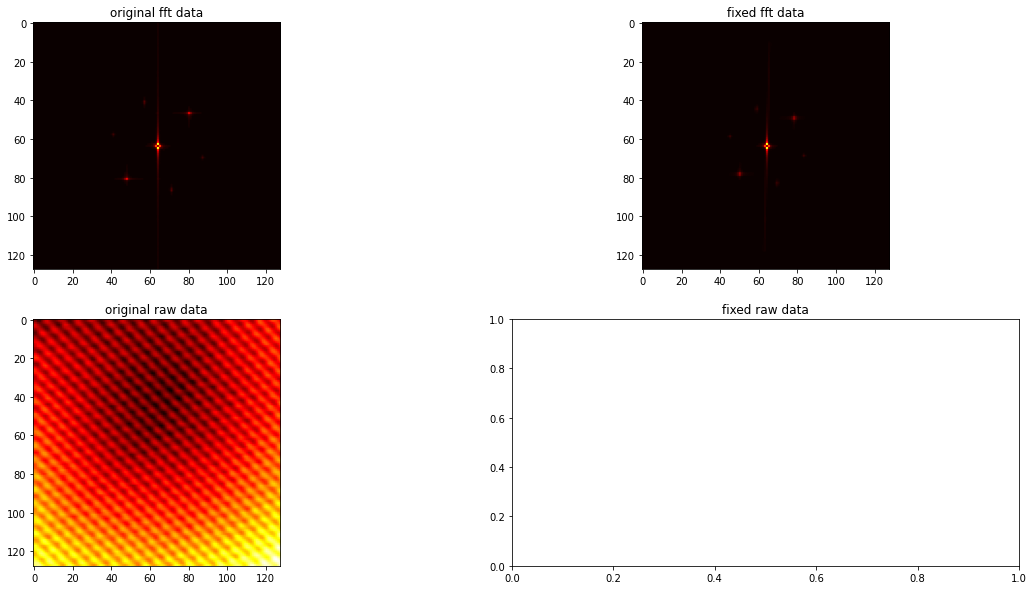

In [ ]:
# transform the image
A = ut.get_correction_matrix(vertices, 20)
fixedfilteredfft = ut.transform_image(filteredfft,A)

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].imshow(filteredfft, cmap="hot")
axs[0, 1].imshow(fixedfilteredfft, cmap="hot")
axs[1, 0].imshow(data, cmap="hot")
# axs[1, 1].imshow(fixeddata, cmap="hot")

axs[0, 0].set_title("original fft data")
axs[0, 1].set_title("fixed fft data")
axs[1, 0].set_title("original raw data")
axs[1, 1].set_title("fixed raw data")

plt.show()